# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [21]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [22]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]
     # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
     # use count_cpgs here to generate labels with temp generated in step2
    
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

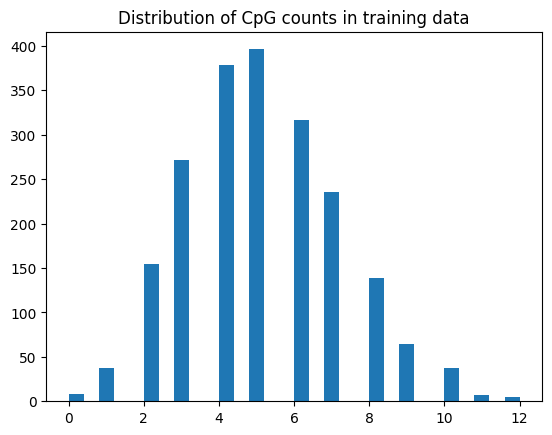

In [23]:
plt.hist(train_y, bins=30)
plt.title("Distribution of CpG counts in training data")
plt.show()

In [24]:
LSTM_HIDDEN = 128
LSTM_LAYER = 2
batch_size = 64
learning_rate = 0.0001
epoch_num = 500
dropout_rate = 0.3
weight_decay = 1e-5
step_size = 10
gamma = 0.5

In [25]:
# Convert lists to torch tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.long)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

test_x_tensor = torch.tensor(test_x, dtype=torch.long)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# Create datasets and DataLoaders
train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_y_tensor)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [26]:
# Model Definition
class CpGPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=1, dropout=0.3):
        super(CpGPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.layer_norm = nn.LayerNorm(2*hidden_size)
        self.fc1 = nn.Linear(2* hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Convert to one-hot encoding
        x = torch.nn.functional.one_hot(x, num_classes=5).float()
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out[:, -1, :])
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits.squeeze()

# Initialize the model
model = CpGPredictor(input_size=5, hidden_size=256, num_layers=2, dropout=0.3)

# Weight Initialization Function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He initialization for FC layers
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param.data)  # Xavier initialization for LSTM
            elif 'bias' in name:
                torch.nn.init.zeros_(param.data)

# Apply weight initialization
model.apply(init_weights)

CpGPredictor(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [27]:
model = CpGPredictor(input_size=5, hidden_size=256, num_layers=1, dropout=0.5)
model.apply(init_weights)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
    {'params': model.lstm.parameters(), 'lr': 0.0005},  # Higher LR for LSTM
    {'params': model.fc1.parameters(), 'lr': 0.001},    # Higher LR for FC layers
    {'params': model.fc2.parameters(), 'lr': 0.001}
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
accumulation_steps = 4


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [28]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CpGPredictor(
  (lstm): LSTM(5, 256, batch_first=True, dropout=0.5, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
for epoch in range(epoch_num):
    model.train()
    t_loss = 0.0
    optimizer.zero_grad()

    # Training loop
    for batch_x, batch_y in train_data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        t_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

    # Compute average training loss
    avg_train_loss = t_loss / len(train_data_loader)
    
    # Validation loop to compute average validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            val_loss += loss.item()

    # Compute average validation loss
    avg_eval_loss = val_loss / len(test_data_loader)
    
    # Step the scheduler based on the validation loss
    scheduler.step(avg_eval_loss)

    # Evaluate metrics every 50 epochs
    if ((epoch + 1) % 50 == 0 or epoch == 0):
        model.eval()
        predictions = []
        ground_truth = []
        with torch.no_grad():
            for batch_x, batch_y in test_data_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                predictions.extend(outputs.tolist())
                ground_truth.extend(batch_y.tolist())

        # Calculate metrics
        mae = mean_absolute_error(ground_truth, predictions)
        mse = mean_squared_error(ground_truth, predictions)
        r2 = r2_score(ground_truth, predictions)

        print(f'Epoch [{epoch+1}/{epoch_num}], MAE: {mae:.4f}, MSE: {mse:.4f}, R-squared: {r2:.4f}')


Epoch [1/500], MAE: 1.6502, MSE: 4.5588, R-squared: -0.0967
Epoch [50/500], MAE: 1.4846, MSE: 3.5262, R-squared: 0.1517
Epoch [100/500], MAE: 1.3671, MSE: 3.0423, R-squared: 0.2681
Epoch [150/500], MAE: 0.4833, MSE: 0.3538, R-squared: 0.9149
Epoch [200/500], MAE: 0.4905, MSE: 0.3307, R-squared: 0.9204
Epoch [250/500], MAE: 0.1679, MSE: 0.0558, R-squared: 0.9866
Epoch [300/500], MAE: 0.1738, MSE: 0.0528, R-squared: 0.9873
Epoch [350/500], MAE: 0.1640, MSE: 0.0490, R-squared: 0.9882
Epoch [400/500], MAE: 0.1617, MSE: 0.0477, R-squared: 0.9885
Epoch [450/500], MAE: 0.1609, MSE: 0.0477, R-squared: 0.9885
Epoch [500/500], MAE: 0.1613, MSE: 0.0471, R-squared: 0.9887


In [32]:
# Evaluation loop
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for batch_x, batch_y in test_data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        predictions.extend(outputs.tolist())
        ground_truth.extend(batch_y.tolist())

# Calculate metrics
mae = mean_absolute_error(ground_truth, predictions)
mse = mean_squared_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Create a DataFrame to display test results
import pandas as pd
df_results = pd.DataFrame({
    'Ground Truth (CpG Count)': ground_truth,
    'Predicted CpG Count': predictions
})

# Display first 15 results
print(df_results.head(15))

Mean Absolute Error (MAE): 0.1613
Mean Squared Error (MSE): 0.0471
R-squared (R2): 0.9887
    Ground Truth (CpG Count)  Predicted CpG Count
0                        4.0             3.782238
1                        4.0             3.876801
2                        7.0             6.935012
3                        5.0             5.210648
4                        4.0             3.676463
5                        4.0             3.618210
6                        6.0             5.800509
7                        8.0             7.683654
8                        6.0             5.971944
9                        9.0             8.979086
10                       7.0             7.082555
11                       6.0             5.785742
12                       4.0             3.912359
13                       9.0             8.490737
14                       4.0             3.984862


In [33]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'{name} gradient mean: {param.grad.mean()}')


lstm.weight_ih_l0 gradient mean: -0.0022412759717553854
lstm.weight_hh_l0 gradient mean: -1.2669936040765606e-05
lstm.bias_ih_l0 gradient mean: -0.01120559312403202
lstm.bias_hh_l0 gradient mean: -0.01120559312403202
lstm.weight_ih_l0_reverse gradient mean: -8.104514677143015e-07
lstm.weight_hh_l0_reverse gradient mean: 0.0
lstm.bias_ih_l0_reverse gradient mean: -4.026307578897104e-06
lstm.bias_hh_l0_reverse gradient mean: -4.026307578897104e-06
layer_norm.weight gradient mean: -0.0003692338359542191
layer_norm.bias gradient mean: 0.00014193126116879284
fc1.weight gradient mean: 1.4551915228366852e-11
fc1.bias gradient mean: -0.0001439254847355187
fc2.weight gradient mean: -0.03338004648685455
fc2.bias gradient mean: -0.11521267145872116


# Part 2: what if the DNA sequences are not the same length

In [2]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [23]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [24]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    
    return X_dna_seqs_train, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [25]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)


In [26]:
class PadSequence:
    def __call__(self, batch):
        # Sort the batch by sequence length in descending order (required by pack_padded_sequence)
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        
        # Separate the sequences and the labels
        sequences, labels = zip(*batch)
        
        # Pad the sequences so that all have the same length
        sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)  # Using 0 for padding
        
        # Get the lengths of each sequence (before padding)
        lengths = torch.LongTensor([len(seq) for seq in sequences])
        
        # Convert labels to a tensor
        labels = torch.FloatTensor(labels)
        
        return sequences_padded, lengths, labels


In [37]:
# Model Definition for Variable Length Sequences
# Model Definition for Variable Length Sequences with Bidirectional LSTM
class CpGPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, num_layers=1, dropout=0.3):
        super(CpGPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)  # Update LayerNorm to handle 2 * hidden_size
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)  # Adjust the input size for fc1
        self.fc2 = nn.Linear(hidden_size, 1)  # fc2 remains unchanged
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        # Convert to one-hot encoding
        x = torch.nn.functional.one_hot(x, num_classes=6).float()
        
        # Pack the padded sequence
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_lstm_out, _ = self.lstm(packed_x)
        
        # Unpack the output
        lstm_out, _ = pad_packed_sequence(packed_lstm_out, batch_first=True)
        
        # Get the last relevant output based on the sequence length
        out = torch.stack([lstm_out[i, lengths[i] - 1, :] for i in range(len(lengths))])

        # Apply layer normalization, dropout, and fully connected layers
        out = self.layer_norm(out)  # Apply LayerNorm to the correct sized output
        out = torch.relu(self.fc1(out))  # Adjust input size for fc1
        out = self.dropout(out)
        logits = self.fc2(out)

        return logits.squeeze()

# Initialize the model
model = CpGPredictor(input_size=5, hidden_size=128, num_layers=1, dropout=0.3)

# Weight Initialization Function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He initialization for FC layers
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param.data)  # Xavier initialization for LSTM
            elif 'bias' in name:
                torch.nn.init.zeros_(param.data)

# Apply weight initialization
model.apply(init_weights)


CpGPredictor(
  (lstm): LSTM(5, 128, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [38]:
# LSTM_HIDDEN = 128
# LSTM_LAYER = 2
batch_size = 64
learning_rate = 0.0001
epoch_num = 500
# dropout_rate = 0.3
weight_decay = 1e-5
# step_size = 10
# gamma = 0.5

In [39]:
# Instantiate the custom Dataset and DataLoader for variable-length sequences
train_dataset = MyDataset(train_x, train_y)
test_dataset = MyDataset(test_x, test_y)

# Instantiate the padding class
pad_sequence_fn = PadSequence()

# DataLoader for training and testing
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_sequence_fn)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_sequence_fn)


In [40]:
# Initialize the model
model = CpGPredictor(input_size=6, hidden_size=256, num_layers=2, dropout=0.3)

# Apply weight initialization
model.apply(init_weights)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CpGPredictor(
  (lstm): LSTM(6, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [42]:
for epoch in range(epoch_num):
    model.train()
    t_loss = 0.0
    optimizer.zero_grad()

    for batch_x, lengths, batch_y in train_data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, lengths)
        loss = loss_fn(outputs, batch_y)
        t_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()
    
    # Compute the average training loss over the epoch
    avg_train_loss = t_loss / len(train_data_loader)
    
    # Step the learning rate scheduler and pass the training loss or validation loss to it
    scheduler.step(avg_train_loss)

    # Evaluate metrics every 50 epochs
    if (epoch + 1) % 50 == 0:
        model.eval()
        predictions = []
        ground_truth = []
        t_loss_eval = 0.0
        with torch.no_grad():
            for batch_x, lengths, batch_y in test_data_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x, lengths)
                predictions.extend(outputs.tolist())
                ground_truth.extend(batch_y.tolist())

                # Calculate the evaluation loss
                eval_loss = loss_fn(outputs, batch_y)
                t_loss_eval += eval_loss.item()

        # Calculate metrics
        mae = mean_absolute_error(ground_truth, predictions)
        mse = mean_squared_error(ground_truth, predictions)
        r2 = r2_score(ground_truth, predictions)
        
        avg_eval_loss = t_loss_eval / len(test_data_loader)  # Average evaluation loss

        print(f'Epoch [{epoch+1}/{epoch_num}], MAE: {mae:.4f}, MSE: {mse:.4f}, R-squared: {r2:.4f}')
        print(f'Epoch [{epoch+1}/{epoch_num}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_eval_loss:.4f}')


Epoch [50/500], MAE: 1.3227, MSE: 2.7245, R-squared: 0.3039
Epoch [50/500], Training Loss: 2.6382, Validation Loss: 2.7245
Epoch [100/500], MAE: 0.7500, MSE: 0.8928, R-squared: 0.7719
Epoch [100/500], Training Loss: 0.9568, Validation Loss: 0.8928
Epoch [150/500], MAE: 0.4971, MSE: 0.4009, R-squared: 0.8976
Epoch [150/500], Training Loss: 0.5766, Validation Loss: 0.4009
Epoch [200/500], MAE: 0.3332, MSE: 0.1782, R-squared: 0.9545
Epoch [200/500], Training Loss: 0.3902, Validation Loss: 0.1782
Epoch [250/500], MAE: 0.3162, MSE: 0.1571, R-squared: 0.9599
Epoch [250/500], Training Loss: 0.3068, Validation Loss: 0.1571
Epoch [300/500], MAE: 0.2583, MSE: 0.1091, R-squared: 0.9721
Epoch [300/500], Training Loss: 0.2827, Validation Loss: 0.1091
Epoch [350/500], MAE: 0.2468, MSE: 0.1017, R-squared: 0.9740
Epoch [350/500], Training Loss: 0.2773, Validation Loss: 0.1017
Epoch [400/500], MAE: 0.2473, MSE: 0.1019, R-squared: 0.9740
Epoch [400/500], Training Loss: 0.2919, Validation Loss: 0.1019
Ep

In [43]:
# Evaluation loop
model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for batch_x, lengths, batch_y in test_data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x, lengths)
        predictions.extend(outputs.tolist())
        ground_truth.extend(batch_y.tolist())

# Calculate metrics
mae = mean_absolute_error(ground_truth, predictions)
mse = mean_squared_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Create a DataFrame to display test results
df_results = pd.DataFrame({
    'Ground Truth (CpG Count)': ground_truth,
    'Predicted CpG Count': predictions
})

# Display first 15 results
print(df_results.head(15))


Mean Absolute Error (MAE): 0.2465
Mean Squared Error (MSE): 0.1015
R-squared (R2): 0.9741
    Ground Truth (CpG Count)  Predicted CpG Count
0                        7.0             6.759179
1                        4.0             3.484550
2                       10.0             9.986917
3                        2.0             2.552635
4                        7.0             6.436924
5                        3.0             3.199556
6                        4.0             4.193299
7                        5.0             5.370790
8                        5.0             5.117517
9                        7.0             6.417596
10                       4.0             4.030716
11                       5.0             5.174898
12                       2.0             2.537110
13                       5.0             5.029013
14                       5.0             4.782869


In [44]:
torch.save(model.state_dict(), 'best_model_lstm.pt')